In [22]:
# Loading required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime 
import xlrd
import re
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn.preprocessing import OneHotEncoder



In [24]:
customerdata = pd.read_csv('')
transactiondata = pd.read_excel('QVI_transaction_data.xlsx')

C:\Users\Venkatesh\anaconda3\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
C:\Users\Venkatesh\anaconda3\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()


In [26]:
customerdata

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream
...,...,...,...
72632,2370651,MIDAGE SINGLES/COUPLES,Mainstream
72633,2370701,YOUNG FAMILIES,Mainstream
72634,2370751,YOUNG FAMILIES,Premium
72635,2370961,OLDER FAMILIES,Budget


In [28]:
# Examining the transaction data - view a summary of the table
trans_df = transactiondata.copy() # Keep a copy for a quick reset 
trans_df

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8
...,...,...,...,...,...,...,...,...
264831,43533,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8
264832,43325,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4
264833,43410,272,272379,270187,51,Doritos Mexicana 170g,2,8.8
264834,43461,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8


In [30]:
# Change date from xls integer dates to date format in customer data
trans_df['DATE'] = pd.to_datetime(trans_df['DATE'], unit='D', origin='1899-12-30')
print(trans_df['DATE'].dtype) # check format of replacement date column 

datetime64[ns]


In [32]:
trans_df

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8
...,...,...,...,...,...,...,...,...
264831,2019-03-09,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8
264832,2018-08-13,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4
264833,2018-11-06,272,272379,270187,51,Doritos Mexicana 170g,2,8.8
264834,2018-12-27,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8


In [34]:
trans_df['PROD_NAME'].unique()

array(['Natural Chip        Compny SeaSalt175g',
       'CCs Nacho Cheese    175g',
       'Smiths Crinkle Cut  Chips Chicken 170g',
       'Smiths Chip Thinly  S/Cream&Onion 175g',
       'Kettle Tortilla ChpsHny&Jlpno Chili 150g',
       'Old El Paso Salsa   Dip Tomato Mild 300g',
       'Smiths Crinkle Chips Salt & Vinegar 330g',
       'Grain Waves         Sweet Chilli 210g',
       'Doritos Corn Chip Mexican Jalapeno 150g',
       'Grain Waves Sour    Cream&Chives 210G',
       'Kettle Sensations   Siracha Lime 150g',
       'Twisties Cheese     270g', 'WW Crinkle Cut      Chicken 175g',
       'Thins Chips Light&  Tangy 175g', 'CCs Original 175g',
       'Burger Rings 220g', 'NCC Sour Cream &    Garden Chives 175g',
       'Doritos Corn Chip Southern Chicken 150g',
       'Cheezels Cheese Box 125g', 'Smiths Crinkle      Original 330g',
       'Infzns Crn Crnchers Tangy Gcamole 110g',
       'Kettle Sea Salt     And Vinegar 175g',
       'Smiths Chip Thinly  Cut Original 175g', 'K

In [40]:
# Remove digits from the product names
prod_name = trans_df['PROD_NAME'].str.replace(r'[0-9]+[gG]','');

# Remove & characters from the product names and replace with a space to separate flavours
prod_name = prod_name.str.replace(r'&',' ');

In [42]:
# Count the frequencies of words in product names and display counts in descending order
word_counts = pd.Series(' '.join(prod_name).split()).value_counts()

with pd.option_context('display.max_rows', None): # show all rows
  display(word_counts)

175g                  60561
Chips                 49770
150g                  41633
Kettle                41288
Smiths                28860
Salt                  27976
Cheese                27890
Pringles              25102
134g                  25102
Doritos               24962
Crinkle               23960
110g                  22387
Corn                  22063
Original              21560
Cut                   20754
Chip                  18645
170g                  18502
Salsa                 18094
Chicken               15407
Chilli                15390
165g                  15297
Sea                   14145
Thins                 14075
Sour                  13882
Crisps                12607
330g                  12540
Vinegar               12402
300g                  12041
RRD                   11894
Sweet                 11060
Infuzions             11057
Supreme               10963
Chives                10951
Cream                 10723
WW                    10320
Popd                

In [44]:
# Remove salsas from the dataset
trans_df = trans_df[trans_df['PROD_NAME'].str.contains(r"[Ss]alsa") == False]
trans_df.shape # check for a reduction in no of rows 

(246742, 8)

In [46]:
# Create summaries of the transaction data
trans_df.describe()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,246742,246742.000000,2.467420e+05,2.467420e+05,246742.000000,246742.000000,246742.000000
mean,2018-12-30 01:19:01.211467520,135.051098,1.355310e+05,1.351311e+05,56.351789,1.908062,7.321322
min,2018-07-01 00:00:00,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,2018-09-30 00:00:00,70.000000,7.001500e+04,6.756925e+04,26.000000,2.000000,5.800000
50%,2018-12-30 00:00:00,130.000000,1.303670e+05,1.351830e+05,53.000000,2.000000,7.400000
75%,2019-03-31 00:00:00,203.000000,2.030840e+05,2.026538e+05,87.000000,2.000000,8.800000
max,2019-06-30 00:00:00,272.000000,2.373711e+06,2.415841e+06,114.000000,200.000000,650.000000
std,NaN,76.787096,8.071528e+04,7.814772e+04,33.695428,0.659831,3.077828


In [48]:
trans_df.isnull().values.any()

False

In [50]:
# Filter the entries that have 200 packets. 
trans_df.loc[trans_df['PROD_QTY'] == 200.0]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


In [52]:
# Filter the entires by the customer
trans_df.loc[trans_df['LYLTY_CARD_NBR'] == 226000]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


In [54]:
# Remove the transactions
trans_df = trans_df[trans_df['LYLTY_CARD_NBR'] != 226000]
trans_df.shape # check for a reduction of 2 rows (i.e. 246740 rows)

(246740, 8)

In [65]:
# Count transactions by date to see if there are any missing days 
count = trans_df.groupby(trans_df['DATE'].dt.date).size().reset_index(name = 'COUNT')
count.shape

(364, 2)

count

In [67]:
count

,DATE,COUNT
0,2018-07-01,663
1,2018-07-02,650
2,2018-07-03,674
3,2018-07-04,669
4,2018-07-05,660
...,...,...
359,2019-06-26,657
360,2019-06-27,669
361,2019-06-28,673
362,2019-06-29,703


In [69]:
# There is one day of data missing. First check the range of dates by sorting in time order. 
trans_df.sort_values(by='DATE')

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
9161,2018-07-01,88,88140,86914,25,Pringles SourCream Onion 134g,2,7.4
155442,2018-07-01,60,60276,57330,3,Kettle Sensations Camembert & Fig 150g,2,9.2
181349,2018-07-01,199,199014,197623,104,Infuzions Thai SweetChili PotatoMix 110g,2,7.6
229948,2018-07-01,35,35052,31630,11,RRD Pc Sea Salt 165g,1,3.0
104647,2018-07-01,72,72104,71038,20,Doritos Cheese Supreme 330g,2,11.4
...,...,...,...,...,...,...,...,...
10254,2019-06-30,112,112141,114611,98,NCC Sour Cream & Garden Chives 175g,2,6.0
113220,2019-06-30,207,207155,205513,99,Pringles Sthrn FriedChicken 134g,2,7.4
229182,2019-06-30,10,10140,9882,12,Natural Chip Co Tmato Hrb&Spce 175g,2,6.0
229015,2019-06-30,6,6258,6047,29,French Fries Potato Chips 175g,1,3.0


In [71]:
trans_df.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [73]:
# Generate a list of dates with transactions in ascending order 
date_counts = trans_df.groupby('DATE').size()

# Then compare to a full list of dates within the same range to find differences between them 
pd.date_range(start = '2018-07-01', end = '2019-06-30' ).difference(date_counts.index)

DatetimeIndex(['2018-12-25'], dtype='datetime64[ns]', freq='D')

In [75]:
# Add a new column to data with packet sizes and extract sizes from product name column
trans_df.insert(8, "PACK_SIZE", trans_df['PROD_NAME'].str.extract('(\d+)').astype(float), True)

# Sort by packet sizes to check for outliers 
trans_df.sort_values(by='PACK_SIZE')

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Venkatesh\AppData\Local\Temp\ipykernel_4936\1567714024.py:2: SyntaxWarning: invalid escape sequence '\d'
  trans_df.insert(8, "PACK_SIZE", trans_df['PROD_NAME'].str.extract('(\d+)').astype(float), True)


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE
40783,2018-09-25,97,97067,96696,38,Infuzions Mango Chutny Papadums 70g,2,4.8,70.0
42461,2019-05-05,110,110030,111890,38,Infuzions Mango Chutny Papadums 70g,2,4.8,70.0
176183,2018-12-30,82,82183,81660,38,Infuzions Mango Chutny Papadums 70g,2,4.8,70.0
227309,2018-12-03,236,236091,239098,38,Infuzions Mango Chutny Papadums 70g,2,4.8,70.0
42418,2018-11-05,109,109217,111470,38,Infuzions Mango Chutny Papadums 70g,2,4.8,70.0
...,...,...,...,...,...,...,...,...,...
192034,2019-03-12,100,100121,99145,4,Dorito Corn Chp Supreme 380g,2,13.0,380.0
255797,2019-01-19,235,235098,238018,4,Dorito Corn Chp Supreme 380g,2,13.0,380.0
233814,2019-01-24,151,151102,149810,4,Dorito Corn Chp Supreme 380g,1,6.5,380.0
131573,2018-07-09,213,213087,212416,4,Dorito Corn Chp Supreme 380g,2,13.0,380.0


C:\Users\Venkatesh\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\Venkatesh\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\Venkatesh\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


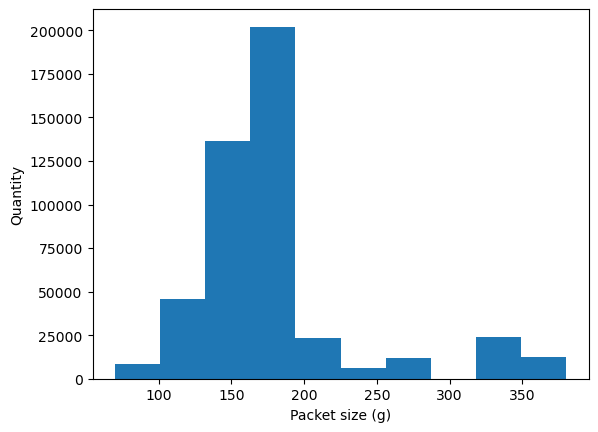

In [77]:
# Minimum packet size is 70g while max is 380g - this is reasonable. 
# Plot a histogram to visualise distribution of pack sizes. 
plt.hist(trans_df['PACK_SIZE'], weights=trans_df['PROD_QTY']);
plt.xlabel('Packet size (g)');
plt.ylabel('Quantity');

In [79]:
# Add a column to extract the first word of each product name to. 
trans_df.insert(9, "BRAND_NAME",trans_df['PROD_NAME'].str.split().str.get(0), True)
trans_df

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND_NAME
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175.0,Natural
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175.0,CCs
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170.0,Smiths
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175.0,Smiths
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150.0,Kettle
...,...,...,...,...,...,...,...,...,...,...
264831,2019-03-09,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8,175.0,Kettle
264832,2018-08-13,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4,175.0,Tostitos
264833,2018-11-06,272,272379,270187,51,Doritos Mexicana 170g,2,8.8,170.0,Doritos
264834,2018-12-27,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8,150.0,Doritos


In [81]:
# Then print all unique entries to check the brand names created
trans_df["BRAND_NAME"].unique()

array(['Natural', 'CCs', 'Smiths', 'Kettle', 'Grain', 'Doritos',
       'Twisties', 'WW', 'Thins', 'Burger', 'NCC', 'Cheezels', 'Infzns',
       'Red', 'Pringles', 'Dorito', 'Infuzions', 'Smith', 'GrnWves',
       'Tyrrells', 'Cobs', 'French', 'RRD', 'Tostitos', 'Cheetos',
       'Woolworths', 'Snbts', 'Sunbites'], dtype=object)

In [83]:
# Create a function to identify the string replacements needed.
def replace_brandname(line):
    name = line['BRAND_NAME']
    if name == "Infzns":
        return "Infuzions"
    elif name == "Red":
        return "Red Rock Deli"
    elif name == "RRD":
        return "Red Rock Deli"
    elif name == "Grain":
        return "Grain Waves"
    elif name == "GrnWves":
        return "Grain Waves"
    elif name == "Snbts":
        return "Sunbites"
    elif name == "Natural":
        return "Natural Chip Co"
    elif name == "NCC":
        return "Natural Chip Co"
    elif name == "WW":
        return "Woolworths"
    elif name == "Smith":
        return "Smiths"
    elif name == "Dorito":
        return "Doritos"
    else:
        return name 

# Then apply the function to clean the brand names
trans_df["BRAND_NAME"] = trans_df.apply(lambda line: replace_brandname(line), axis=1)

# Check that there are no duplicate brands 
trans_df["BRAND_NAME"].unique()

array(['Natural Chip Co', 'CCs', 'Smiths', 'Kettle', 'Grain Waves',
       'Doritos', 'Twisties', 'Woolworths', 'Thins', 'Burger', 'Cheezels',
       'Infuzions', 'Red Rock Deli', 'Pringles', 'Tyrrells', 'Cobs',
       'French', 'Tostitos', 'Cheetos', 'Sunbites'], dtype=object)

In [85]:
# Now examine customer data
cust_df = customerdata.copy()
cust_df.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [87]:
# Rename "PREMIUM_CUSTOMER" to "MEMBER_TYPE" for easier identification of the column data
cust_df = cust_df.rename(columns={'PREMIUM_CUSTOMER': 'MEMBER_TYPE'})

In [89]:
# Check the summary of the customer data
cust_df.describe()

,LYLTY_CARD_NBR
count,7.263700e+04
mean,1.361859e+05
std,8.989293e+04
min,1.000000e+03
25%,6.620200e+04
50%,1.340400e+05
75%,2.033750e+05
max,2.373711e+06


In [91]:
# Check the entries in the member type and lifestage columns
cust_df["MEMBER_TYPE"].unique()

array(['Premium', 'Mainstream', 'Budget'], dtype=object)

In [93]:
cust_df["LIFESTAGE"].unique()

array(['YOUNG SINGLES/COUPLES', 'YOUNG FAMILIES', 'OLDER SINGLES/COUPLES',
       'MIDAGE SINGLES/COUPLES', 'NEW FAMILIES', 'OLDER FAMILIES',
       'RETIREES'], dtype=object)

In [95]:
# Join the customer and transaction datasets, and sort transactons by date 
full_df = trans_df.set_index('LYLTY_CARD_NBR').join(cust_df.set_index('LYLTY_CARD_NBR'))
full_df = full_df.reset_index()
full_df = full_df.sort_values(by='DATE').reset_index(drop=True)
full_df

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND_NAME,LIFESTAGE,MEMBER_TYPE
0,88140,2018-07-01,88,86914,25,Pringles SourCream Onion 134g,2,7.4,134.0,Pringles,MIDAGE SINGLES/COUPLES,Mainstream
1,60276,2018-07-01,60,57330,3,Kettle Sensations Camembert & Fig 150g,2,9.2,150.0,Kettle,RETIREES,Mainstream
2,199014,2018-07-01,199,197623,104,Infuzions Thai SweetChili PotatoMix 110g,2,7.6,110.0,Infuzions,RETIREES,Premium
3,35052,2018-07-01,35,31630,11,RRD Pc Sea Salt 165g,1,3.0,165.0,Red Rock Deli,YOUNG SINGLES/COUPLES,Budget
4,72104,2018-07-01,72,71038,20,Doritos Cheese Supreme 330g,2,11.4,330.0,Doritos,OLDER SINGLES/COUPLES,Mainstream
...,...,...,...,...,...,...,...,...,...,...,...,...
246735,112141,2019-06-30,112,114611,98,NCC Sour Cream & Garden Chives 175g,2,6.0,175.0,Natural Chip Co,MIDAGE SINGLES/COUPLES,Mainstream
246736,207155,2019-06-30,207,205513,99,Pringles Sthrn FriedChicken 134g,2,7.4,134.0,Pringles,OLDER SINGLES/COUPLES,Mainstream
246737,10140,2019-06-30,10,9882,12,Natural Chip Co Tmato Hrb&Spce 175g,2,6.0,175.0,Natural Chip Co,YOUNG SINGLES/COUPLES,Budget
246738,6258,2019-06-30,6,6047,29,French Fries Potato Chips 175g,1,3.0,175.0,French,YOUNG SINGLES/COUPLES,Budget


In [97]:
# Check for nulls in the full dataset
full_df.isnull().values.any()

False

In [99]:
# looks like all the data is reasonable so export to CSV
full_df.to_csv('QVI_fulldata.csv')

In [101]:

# calculate total sales by lifestage and member type and generate a list  
total_sales_cust = full_df.groupby(['LIFESTAGE','MEMBER_TYPE'], as_index = False)['TOT_SALES'].agg(['sum'])
total_sales_cust = total_sales_cust.rename(columns={'sum': 'sum_tot_sales'})
total_sales_cust.sort_values(by = "sum_tot_sales", ascending = False)

,LIFESTAGE,MEMBER_TYPE,sum_tot_sales
6,OLDER FAMILIES,Budget,156863.75
19,YOUNG SINGLES/COUPLES,Mainstream,147582.20
13,RETIREES,Mainstream,145168.95
15,YOUNG FAMILIES,Budget,129717.95
9,OLDER SINGLES/COUPLES,Budget,127833.60
10,OLDER SINGLES/COUPLES,Mainstream,124648.50
11,OLDER SINGLES/COUPLES,Premium,123537.55
12,RETIREES,Budget,105916.30
7,OLDER FAMILIES,Mainstream,96413.55
14,RETIREES,Premium,91296.65


Text(0.5, 1.0, 'Total Sales Distributions By Customer Lifestage and Affluence')

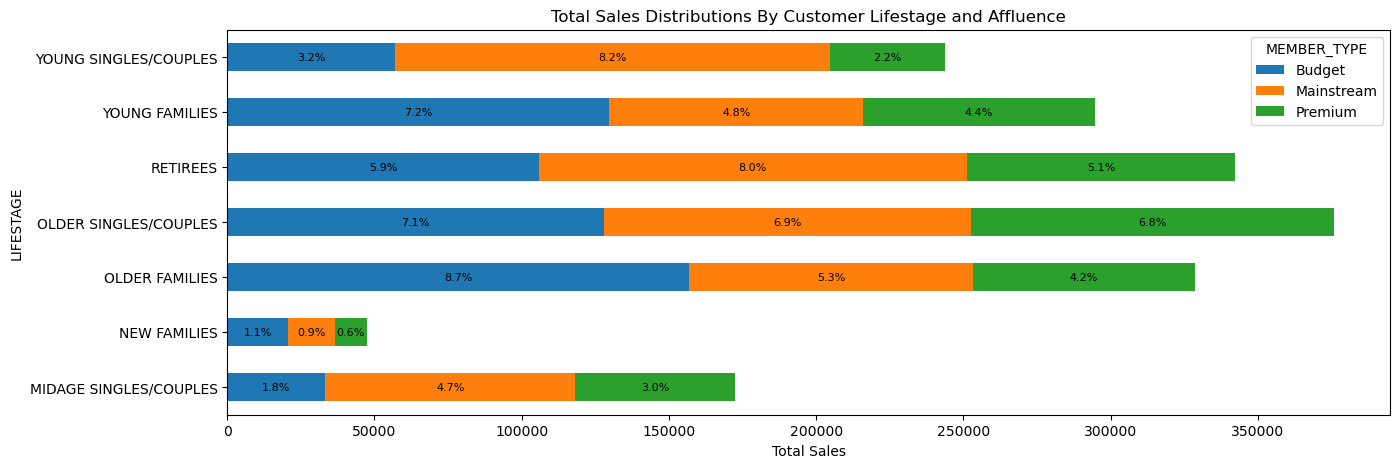

In [107]:
# Get the total sales 
total_sales = full_df['TOT_SALES'].agg(['sum'])['sum']

# Plot a breakdown of the total sales by lifestage and member type
total_sales_breakdown = full_df.groupby(['LIFESTAGE', 'MEMBER_TYPE'], as_index=False)['TOT_SALES'].agg(['sum', 'mean']).reset_index()

# Ensure the DataFrame is structured correctly for unstacking
total_sales_breakdown = total_sales_breakdown.set_index(['LIFESTAGE', 'MEMBER_TYPE']).unstack(level='MEMBER_TYPE').fillna(0)

# Plotting the bar chart
ax = total_sales_breakdown['sum'].plot(kind='barh', stacked=True, figsize=(15, 5))

# Add percentages of the summed total sales as labels to each bar 
for rect in ax.patches:
    height = rect.get_height()
    width = rect.get_width()
    label = width / total_sales * 100
    x = rect.get_x()
    y = rect.get_y()
    
    label_text = f'{(label):.1f}%' 
    
    # Set label positions
    label_x = x + width / 2
    label_y = y + height / 2
    
    # only plot labels greater than given width
    if width > 0:
        ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=8)
        
ax.set_xlabel("Total Sales")
ax.set_title('Total Sales Distributions By Customer Lifestage and Affluence')

In [109]:
total_sales_breakdown


index                           sum             \
MEMBER_TYPE            Budget Mainstream Premium     Budget Mainstream   
LIFESTAGE                                                                
MIDAGE SINGLES/COUPLES      0          1       2   33345.70   84734.25   
NEW FAMILIES                3          4       5   20607.45   15979.70   
OLDER FAMILIES              6          7       8  156863.75   96413.55   
OLDER SINGLES/COUPLES       9         10      11  127833.60  124648.50   
RETIREES                   12         13      14  105916.30  145168.95   
YOUNG FAMILIES             15         16      17  129717.95   86338.25   
YOUNG SINGLES/COUPLES      18         19      20   57122.10  147582.20   

                                       mean                       
MEMBER_TYPE               Premium    Budget Mainstream   Premium  
LIFESTAGE                                                         
MIDAGE SINGLES/COUPLES   54443.85  7.108442   7.637156  7.152371  
NEW FAMILIES             10760.80  7.297256   7.313364  7.231720  
OLDER FAMILIES           75242.60  7.291241   7.281440  7.232779  
OLDER SINGLES/COUPLES   123537.55  7.444305   7.306049  7.459997  
RETIREES                 91296.65  7.445786   7.269352  7.461315  
YOUNG FAMILIES           78571.70  7.302705   7.226772  7.285951  
YOUNG SINGLES/COUPLES    39052.30  6.663023   7.551279  6.673325

In [111]:
# Check all rows are unique in customer information
len(cust_df['LYLTY_CARD_NBR'].unique()) == cust_df.shape[0]

True

In [113]:
# Check if all customers made chip purchases. 
len(cust_df['LYLTY_CARD_NBR'].unique()) == len(full_df['LYLTY_CARD_NBR'].unique())

False

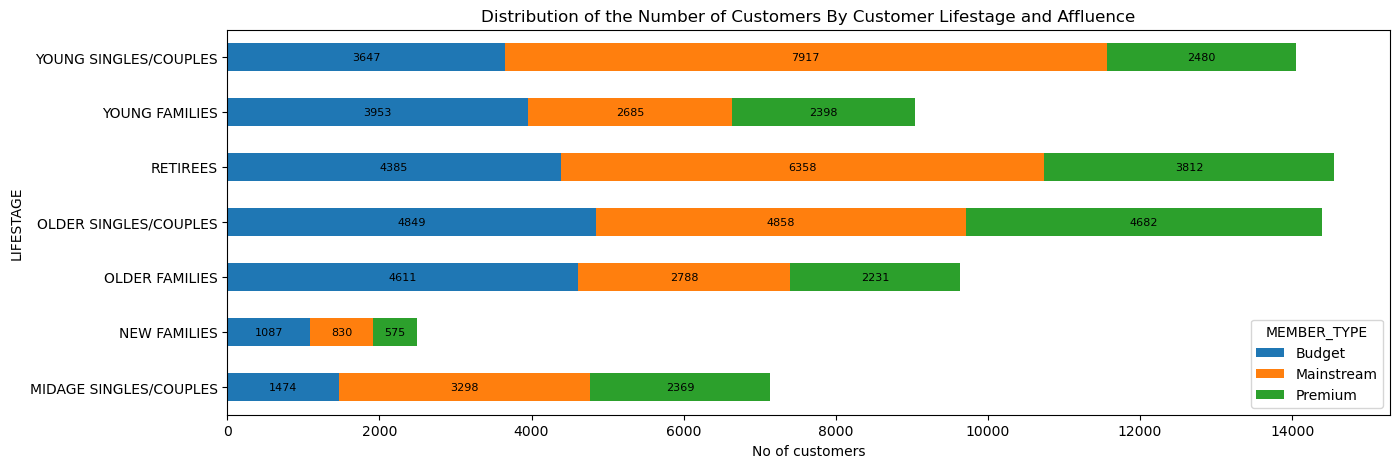

In [115]:
# Plot the numbers of customers in each segment by counting the unique LYLTY_CARD_NBR entries
sum_customers= full_df.groupby(['LIFESTAGE','MEMBER_TYPE'])['LYLTY_CARD_NBR'].agg('nunique').unstack('MEMBER_TYPE').fillna(0)
ax = sum_customers.plot(kind='barh', stacked=True, figsize=(15, 5))

# Add customer numbers as labels to each bar 
# .patches is everything inside of the chart
for rect in ax.patches:
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()
    
    label_text = f'{(width):.0f}'
    
    # Set label positions
    label_x = x + width / 2
    label_y = y + height / 2
    
    # only plot labels greater than given width
    if width > 0:
        ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=8)
        
ax.set_xlabel("No of customers")
ax.set_title('Distribution of the Number of Customers By Customer Lifestage and Affluence')
plt.show()

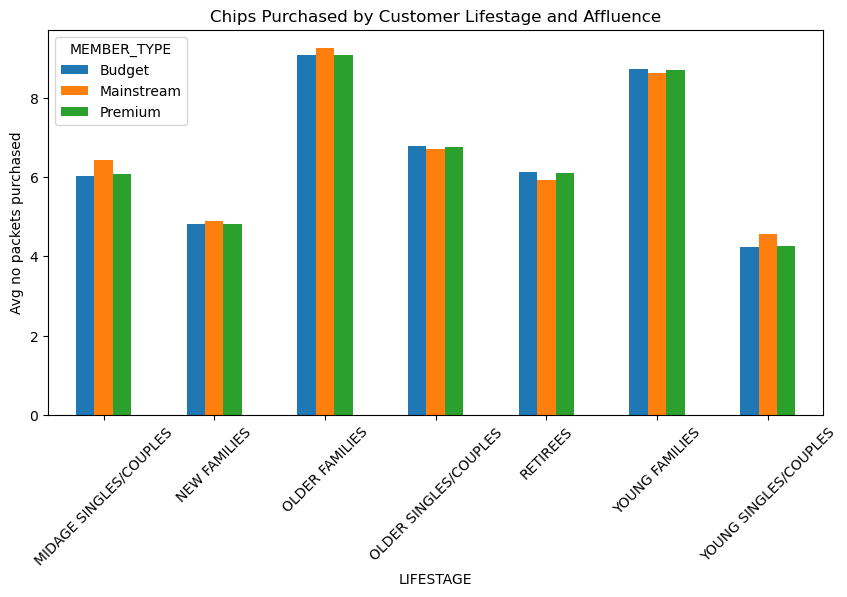

In [117]:
# Plot the average no of chip packets bought per customer by LIFESTAGE and MEMBER_TYPE.
no_packets_data = full_df.groupby(['LIFESTAGE','MEMBER_TYPE'])['PROD_QTY'].sum()/full_df.groupby(['LIFESTAGE','MEMBER_TYPE'])['LYLTY_CARD_NBR'].nunique(0)
ax = no_packets_data.unstack('MEMBER_TYPE').fillna(0).plot.bar(stacked = False,figsize=(10, 5))
ax.set_ylabel("Avg no packets purchased")
ax.set_title('Chips Purchased by Customer Lifestage and Affluence')
plt.xticks(rotation=45)
plt.show()

In [119]:
# Create a column for the unit price of chips purchased per transaction 
full_df['UNIT_PRICE'] = full_df['TOT_SALES']/full_df['PROD_QTY']

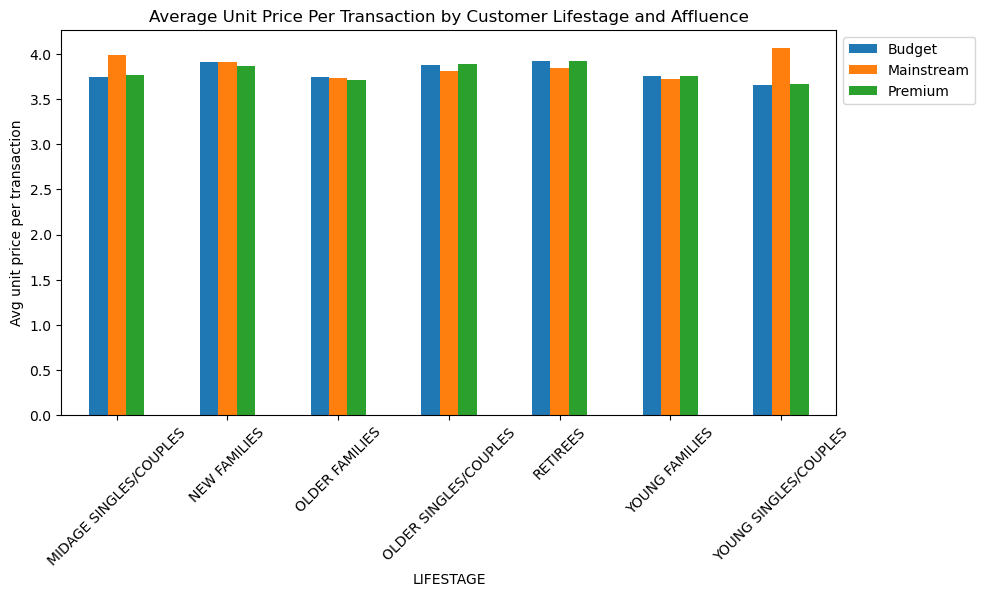

In [123]:
# Plot the distribution of the average unit price per transaction by LIFESTAGE and MEMBER_TYPE.
avg_priceperunit = full_df.groupby(['LIFESTAGE', 'MEMBER_TYPE'], as_index = False)['UNIT_PRICE'].agg(['mean']).reset_index()

# Ensure the DataFrame is structured correctly for unstacking
avg_priceperunit = avg_priceperunit.set_index(['LIFESTAGE', 'MEMBER_TYPE']).unstack(level='MEMBER_TYPE').fillna(0)


ax = avg_priceperunit['mean'].plot.bar(stacked=False, figsize=(10, 5))
ax.set_ylabel("Avg unit price per transaction")
ax.set_title('Average Unit Price Per Transaction by Customer Lifestage and Affluence')
plt.legend(loc = "upper left",bbox_to_anchor=(1.0, 1.0))
plt.xticks(rotation=45)
plt.show()

In [125]:
# Check the difference in the average price unit between the mainstream and premium/budget groups for young/midage singles/couples
from scipy.stats import ttest_ind

# Identify the groups to test the hypthesis with 
mainstream = full_df["MEMBER_TYPE"] == "Mainstream"
young_midage = (full_df["LIFESTAGE"] == "MIDAGE SINGLES/COUPLES") | (full_df["LIFESTAGE"] == "YOUNG SINGLES/COUPLES")
premium_budget = full_df["MEMBER_TYPE"] != "Mainstream"

group1 = full_df[mainstream & young_midage]["UNIT_PRICE"]
group2 = full_df[premium_budget & young_midage]["UNIT_PRICE"]

# Generate the t-test 
stat, pval = ttest_ind(group1.values, group2.values, equal_var=False)

print(pval, stat)

6.967354233018139e-306 37.6243885962295


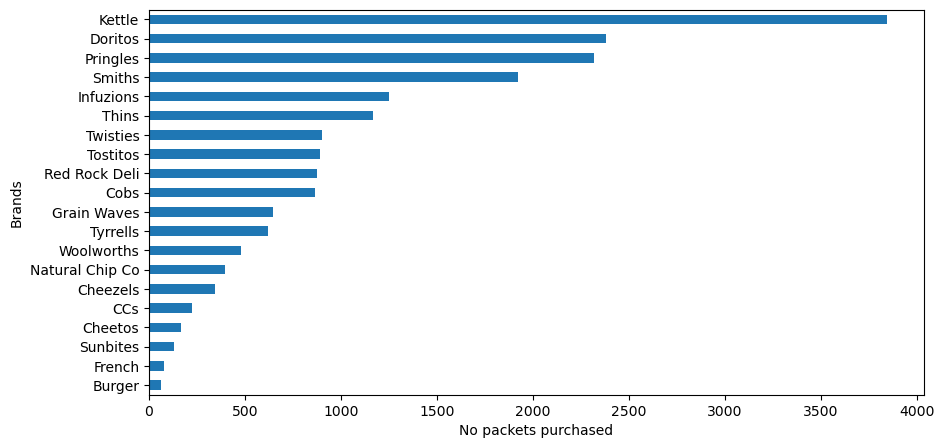

In [127]:
# Create a visual of what brands young singles/couples are purchasing the most for a general indication
young_mainstream = full_df.loc[full_df['LIFESTAGE'] == "YOUNG SINGLES/COUPLES"]
young_mainstream = young_mainstream.loc[young_mainstream['MEMBER_TYPE'] == "Mainstream"]
ax = young_mainstream["BRAND_NAME"].value_counts().sort_values(ascending = True).plot.barh(figsize=(10, 5))
ax.set_xlabel("No packets purchased")
ax.set_ylabel("Brands")
plt.show()

In [129]:
temp = full_df.copy()
temp["group"] = temp["LIFESTAGE"] + ' - ' + temp['MEMBER_TYPE']
groups = pd.get_dummies(temp["group"])
brands = pd.get_dummies(temp["BRAND_NAME"])
groups_brands = groups.join(brands)
groups_brands

,MIDAGE SINGLES/COUPLES - Budget,MIDAGE SINGLES/COUPLES - Mainstream,MIDAGE SINGLES/COUPLES - Premium,NEW FAMILIES - Budget,NEW FAMILIES - Mainstream,NEW FAMILIES - Premium,OLDER FAMILIES - Budget,OLDER FAMILIES - Mainstream,OLDER FAMILIES - Premium,OLDER SINGLES/COUPLES - Budget,...,Natural Chip Co,Pringles,Red Rock Deli,Smiths,Sunbites,Thins,Tostitos,Twisties,Tyrrells,Woolworths
0,False,True,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246735,False,True,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
246736,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
246737,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
246738,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [153]:
from mlxtend.frequent_patterns import apriori, association_rules

# Generate frequent itemsets
freq_groupsbrands = apriori(groups_brands, min_support=0.008, use_colnames=True)

# Check if any itemsets were generated
if freq_groupsbrands.empty:
    print("No frequent itemsets found. Try lowering the min_support value.")
else:
    # Add the number of items in each itemset
    freq_groupsbrands['nums_itemset'] = freq_groupsbrands['itemsets'].apply(len)

    # Generate association rules
    rules = association_rules(freq_groupsbrands, metric="lift", min_threshold=0.5,num_itemsets=1)

    # Check if any rules were generated
    if rules.empty:
        print("No association rules found. Adjust the metric or min_threshold values.")
    else:
        # Sort rules by confidence
        rules.sort_values('confidence', ascending=False, inplace=True)
        print("Top rules:")
        print(rules.head())  # Display the top rules


Top rules:
                              antecedents consequents  antecedent support  \
41   (YOUNG SINGLES/COUPLES - Mainstream)    (Kettle)            0.079209   
1   (MIDAGE SINGLES/COUPLES - Mainstream)    (Kettle)            0.044966   
22                    (RETIREES - Budget)    (Kettle)            0.057652   
32                   (RETIREES - Premium)    (Kettle)            0.049591   
12       (OLDER SINGLES/COUPLES - Budget)    (Kettle)            0.069596   

    consequent support   support  confidence      lift  representativity  \
41            0.167334  0.015579    0.196684  1.175400               1.0   
1             0.167334  0.008657    0.192519  1.150508               1.0   
22            0.167334  0.010505    0.182214  1.088926               1.0   
32            0.167334  0.008981    0.181105  1.082296               1.0   
12            0.167334  0.012422    0.178488  1.066658               1.0   

    leverage  conviction  zhangs_metric   jaccard  certainty  kulczyn

In [155]:
set_temp = temp["group"].unique()
rules[rules["antecedents"].apply(lambda x: list(x)).apply(lambda x: x in set_temp)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
41,(YOUNG SINGLES/COUPLES - Mainstream),(Kettle),0.079209,0.167334,0.015579,0.196684,1.175400,1.0,0.002325,1.036537,0.162062,0.067453,0.035249,0.144893
1,(MIDAGE SINGLES/COUPLES - Mainstream),(Kettle),0.044966,0.167334,0.008657,0.192519,1.150508,1.0,0.001132,1.031190,0.136978,0.042510,0.030246,0.122127
22,(RETIREES - Budget),(Kettle),0.057652,0.167334,0.010505,0.182214,1.088926,1.0,0.000858,1.018196,0.086660,0.048979,0.017871,0.122496
32,(RETIREES - Premium),(Kettle),0.049591,0.167334,0.008981,0.181105,1.082296,1.0,0.000683,1.016816,0.080006,0.043190,0.016538,0.117388
12,(OLDER SINGLES/COUPLES - Budget),(Kettle),0.069596,0.167334,0.012422,0.178488,1.066658,1.0,0.000776,1.013578,0.067167,0.055330,0.013396,0.126361
20,(OLDER SINGLES/COUPLES - Premium),(Kettle),0.067115,0.167334,0.011944,0.177959,1.063495,1.0,0.000713,1.012925,0.064000,0.053678,0.012760,0.124668
26,(RETIREES - Mainstream),(Kettle),0.080935,0.167334,0.013723,0.169554,1.013269,1.0,0.000180,1.002674,0.014248,0.058508,0.002666,0.125782
16,(OLDER SINGLES/COUPLES - Mainstream),(Kettle),0.069146,0.167334,0.011490,0.166168,0.993034,1.0,-0.000081,0.998602,-0.007479,0.051068,-0.001400,0.117416
34,(YOUNG FAMILIES - Budget),(Kettle),0.071991,0.167334,0.011117,0.154422,0.922837,1.0,-0.000930,0.984730,-0.082654,0.048714,-0.015507,0.110429
4,(OLDER FAMILIES - Budget),(Kettle),0.087193,0.167334,0.013455,0.154318,0.922216,1.0,-0.001135,0.984609,-0.084586,0.055815,-0.015632,0.117364


In [157]:
rules[rules['antecedents'] == {'YOUNG SINGLES/COUPLES - Mainstream'}]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
41,(YOUNG SINGLES/COUPLES - Mainstream),(Kettle),0.079209,0.167334,0.015579,0.196684,1.175400,1.0,0.002325,1.036537,0.162062,0.067453,0.035249,0.144893
39,(YOUNG SINGLES/COUPLES - Mainstream),(Doritos),0.079209,0.102229,0.009642,0.121725,1.190712,1.0,0.001544,1.022198,0.173944,0.056123,0.021716,0.108020
43,(YOUNG SINGLES/COUPLES - Mainstream),(Pringles),0.079209,0.101735,0.009382,0.118451,1.164310,1.0,0.001324,1.018962,0.153262,0.054688,0.018609,0.105337


In [159]:
 #find the target rating proportion
target_segment = young_mainstream["BRAND_NAME"].value_counts().sort_values(ascending = True).rename_axis('BRANDS').reset_index(name='target')
target_segment.target /= young_mainstream["PROD_QTY"].sum()

# find the other rating proportion
not_young_mainstream = full_df.loc[full_df['LIFESTAGE'] != "YOUNG SINGLES/COUPLES"]
not_young_mainstream = not_young_mainstream.loc[not_young_mainstream['MEMBER_TYPE'] != "Mainstream"]
other = not_young_mainstream["BRAND_NAME"].value_counts().sort_values(ascending = True).rename_axis('BRANDS').reset_index(name='other')
other.other /= not_young_mainstream["PROD_QTY"].sum()

# join the two dataframes 
brand_proportions = target_segment.set_index('BRANDS').join(other.set_index('BRANDS'))
# full_df = trans_df.set_index('LYLTY_CARD_NBR').join(cust_df.set_index('LYLTY_CARD_NBR'))
brand_proportions = brand_proportions.reset_index()
brand_proportions['affinity'] = brand_proportions['target']/brand_proportions['other']
brand_proportions.sort_values(by = 'affinity', ascending = False)

,BRANDS,target,other,affinity
8,Tyrrells,0.017088,0.013368,1.278270
13,Twisties,0.024845,0.019632,1.265496
18,Doritos,0.065673,0.052511,1.250646
12,Tostitos,0.024569,0.019944,1.231911
19,Kettle,0.106115,0.086574,1.225712
17,Pringles,0.063906,0.052477,1.217793
10,Cobs,0.023851,0.020004,1.192293
15,Infuzions,0.034507,0.029930,1.152890
9,Grain Waves,0.017833,0.016214,1.099878
14,Thins,0.032188,0.029771,1.081172


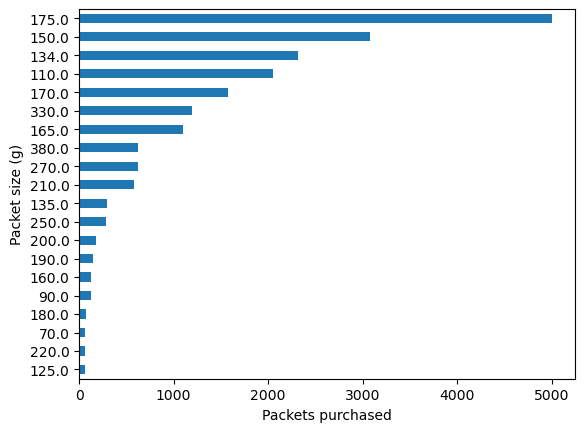

In [161]:
# Plot the distribution of the packet sizes for a general indication of what it most popular. 
young_mainstream = full_df.loc[full_df['LIFESTAGE'] == "YOUNG SINGLES/COUPLES"]
young_mainstream = young_mainstream.loc[young_mainstream['MEMBER_TYPE'] == "Mainstream"]
ax = young_mainstream["PACK_SIZE"].value_counts().sort_values(ascending = True).plot.barh()
ax.set_ylabel("Packet size (g)")
ax.set_xlabel("Packets purchased")
plt.show()

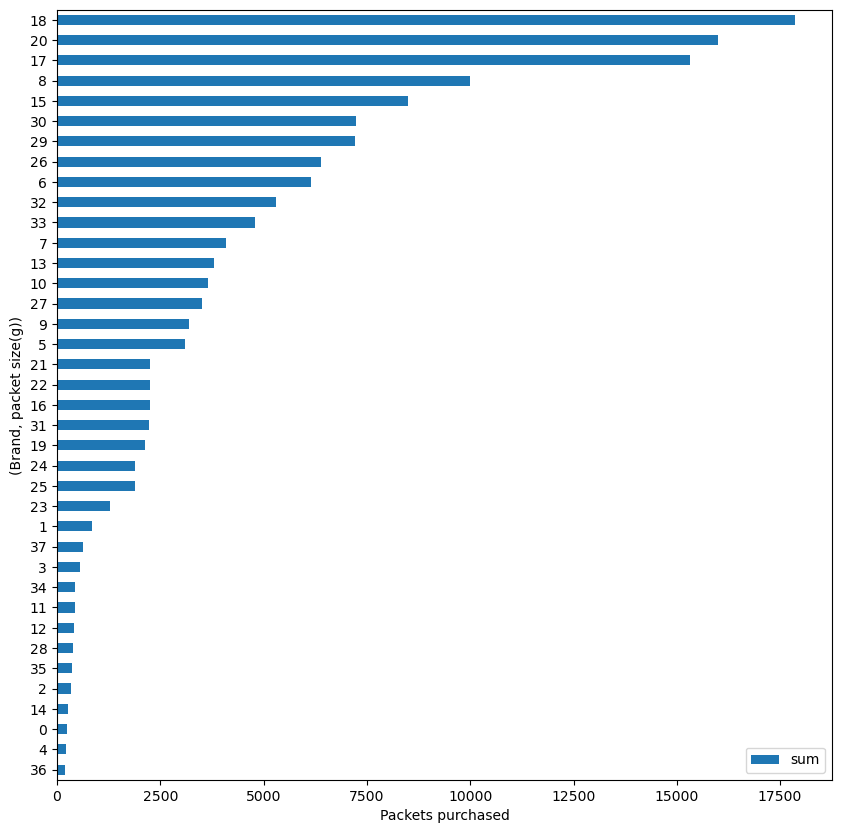

In [163]:
# Also want to check which brands correspond to what sized packets. 
brand_size = young_mainstream.groupby(['BRAND_NAME','PACK_SIZE'], as_index = False)['TOT_SALES'].agg(['sum'])
ax = brand_size.sort_values(by = 'sum').plot.barh(y = "sum", figsize=(10,10))
ax.set_ylabel("(Brand, packet size(g))")
ax.set_xlabel("Packets purchased")
plt.show()

In [165]:
groups = pd.get_dummies(temp["group"])
brands = pd.get_dummies(temp["PACK_SIZE"])
groups_brands = groups.join(brands)
groups_brands

,MIDAGE SINGLES/COUPLES - Budget,MIDAGE SINGLES/COUPLES - Mainstream,MIDAGE SINGLES/COUPLES - Premium,NEW FAMILIES - Budget,NEW FAMILIES - Mainstream,NEW FAMILIES - Premium,OLDER FAMILIES - Budget,OLDER FAMILIES - Mainstream,OLDER FAMILIES - Premium,OLDER SINGLES/COUPLES - Budget,...,175.0,180.0,190.0,200.0,210.0,220.0,250.0,270.0,330.0,380.0
0,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246735,False,True,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
246736,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
246737,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
246738,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False


In [169]:
# find the target rating proportion
target_segment = young_mainstream["PACK_SIZE"].value_counts().sort_values(ascending = True).rename_axis('SIZES').reset_index(name='target')
target_segment.target /= young_mainstream["PROD_QTY"].sum()

# find the other rating proportion
other = not_young_mainstream["PACK_SIZE"].value_counts().sort_values(ascending = True).rename_axis('SIZES').reset_index(name='other')
other.other /= not_young_mainstream["PROD_QTY"].sum()

# join the two dataframes 
brand_proportions = target_segment.set_index('SIZES').join(other.set_index('SIZES'))
brand_proportions = brand_proportions.reset_index()
brand_proportions['affinity'] = brand_proportions['target']/brand_proportions['other']
brand_proportions.sort_values(by = 'affinity', ascending = False)

,SIZES,target,other,affinity
11,270.0,0.017115,0.012958,1.320826
12,380.0,0.017281,0.013375,1.291992
14,330.0,0.032988,0.026455,1.246968
10,210.0,0.015901,0.012973,1.225655
17,134.0,0.063906,0.052477,1.217793
16,110.0,0.056618,0.046653,1.213618
9,135.0,0.008006,0.006750,1.185951
8,250.0,0.007729,0.006674,1.158076
15,170.0,0.043478,0.041826,1.039502
18,150.0,0.085024,0.084969,1.000652
